# Active Learning with Bayesian Linear Regression
> A programming introduction to Active Learning with Bayesian Linear Regression.

- toc: true 
- badges: true
- comments: true
- image: images/ALBLR.gif
- author: Zeel Patel & Nipun Batra
- categories: [ML]


### A quick wrap-up for Bayesian Linear Regression (BLR)

We have a feature matrix $X$ and a target vector $Y$. We want to obtain $\theta$ vector in such a way that the error $\epsilon$ for the following equation is minimum.

\begin{equation}
Y = X^T\theta + \epsilon
\end{equation}
Prior PDF for $\theta$ is,

\begin{equation}
p(\theta) \sim \mathcal{N}(M_0, S_0)
\end{equation}

Where $S_0$ is prior covariance matrix, and $M_0$ is prior mean. 

Posterier PDF can be given as,

\begin{equation}
p(\theta|X,Y) \sim \mathcal{N}(\theta | M_n, S_n) \\
S_n = (S_0^{-1} + \sigma_{mle}^{-2}X^TX) \\
M_n = S_n(S_0^{-1}M_0+\sigma_{mle}^{-2}X^TY)
\end{equation}


Maximum likelihood estimation of $\sigma$ can be calculated as,  

\begin{equation}
\theta_{mle} = (X^TX)^{-1}X^TY \\
\sigma_{mle} = ||Y - X^T\theta_{mle}||
\end{equation}

Finally, predicted mean $\hat{Y}_{mean}$ and predicted covariance matrix $\hat{Y}_{cov}$ can be given as,

\begin{equation}
\hat{Y} \sim \mathcal{N}(\hat{Y}_{mean}, \hat{Y}_{cov}) \\
\hat{Y}_{mean} = XM_n \\
\hat{Y}_{cov} = X^TS_nX
\end{equation}

Now, let's put everything together and write a class for [Bayesian Linear Regression](https://nipunbatra.github.io/blog/ml/2020/02/20/bayesian-linear-regression.html).

### Creating scikit-learn like class with fit predict methods for BLR

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib.animation import FuncAnimation
from matplotlib import rc
import warnings
warnings.filterwarnings('ignore')
seed = 0 # random seed for train_test_split

In [2]:
class BLR():
    def __init__(self,S0, M0): # M0 -> prior mean, S0 -> prior covariance matrix
        self.S0 = S0
        self.M0 = M0

    def fit(self,x,y, return_self = False):
        self.x = x
        self.y = y

        # Maximum likelihood estimation for sigma parameter
        theta_mle = np.linalg.pinv(x.T@x)@(x.T@y)
        sigma_2_mle = np.linalg.norm(y - x@theta_mle)**2
        sigma_mle = np.sqrt(sigma_2_mle)

        # Calculating predicted mean and covariance matrix for theta
        self.SN = np.linalg.pinv(np.linalg.pinv(self.S0) + (sigma_mle**-2)*x.T@x)
        self.MN = self.SN@(np.linalg.pinv(self.S0)@self.M0 + (sigma_mle**-2)*(x.T@y).squeeze())

        # Calculating predicted mean and covariance matrix for data
        self.pred_var = x@self.SN@x.T
        self.y_hat_map = x@self.MN
        if return_self:
            return (self.y_hat_map, self.pred_var)

    def predict(self, x):
        self.pred_var = x@self.SN@x.T
        self.y_hat_map = x@self.MN
        return (self.y_hat_map, self.pred_var)

    def plot(self, s=1): # s -> size of dots for scatter plot
        individual_var = self.pred_var.diagonal()
        plt.figure()
        plt.xlabel('x')
        plt.ylabel('y')
        plt.plot(self.x[:,1], self.y_hat_map, color='black', label='model')
        plt.fill_between(self.x[:,1], self.y_hat_map-individual_var, self.y_hat_map+individual_var, alpha=0.4, color='black', label='uncertainty')
        plt.scatter(self.x[:,1], self.y, label='actual data',s=s)
        plt.title('MAE is '+str(np.mean(np.abs(self.y - self.y_hat_map))))
        plt.legend()

### Creating & visualizing dataset

To start with, let's create a random dataset with degree 3 polynomial function with some added noise.

\begin{equation}
Y = (5X^3 - 4X^2 + 3X - 2) + \mathcal{N}(0,1)
\end{equation}

In [3]:
np.random.seed(seed)
X_init = np.linspace(-1, 1, 1000)
noise = np.random.randn(1000, )
Y = (5 * X_init**3 - 4 * X_init**2 + 3 * X_init - 2) + noise

### Reading the energy data from the system

In [4]:
b1 = pd.read_csv('JULY_B_2019.csv')
b2 = pd.read_csv('August_B_2019.csv')
#b3 = pd.read_csv('MAY_B_2019.csv')

In [5]:
data_beauki = pd.concat([b1,b2],axis=0)

In [6]:
data_beauki['23:40'] = 0

In [7]:
data_beauki = data_beauki.drop(['Date'],axis=1)

In [8]:
from itertools import chain 
beauki = list(chain.from_iterable(list(data_beauki.values)))

In [9]:
X_init = np.array(beauki[:len(beauki)-1])
Y = beauki[1:len(beauki)]

We'll try to fit a degree 5 polynomial function to our data.

In [10]:
X = PolynomialFeatures(degree=3, include_bias=True).fit_transform(X_init.reshape(-1,1))
N_features = X.shape[1]

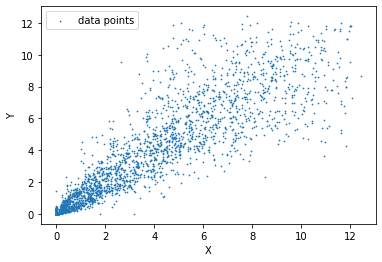

In [11]:
plt.scatter(X[:,1], Y, s=0.5, label = 'data points')
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

### Learning a BLR model on the entire data

We'll take $M_0$ (prior mean) as zero vector initially, assuming that we do not have any prior knowledge about $M_0$. We're taking $S_0$ (prior covariance) as the identity matrix, assuming that all coefficients are completely independent of each other.

In [15]:
S0 = np.eye(N_features)
M0 = np.zeros((N_features, ))
model = BLR(S0, M0)

In [16]:
model.fit(X, Y)

### Visualising the fit

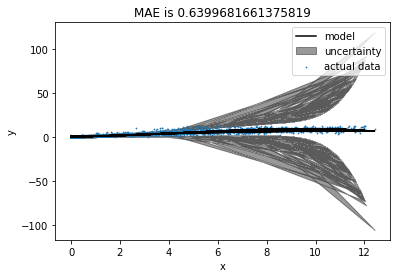

In [21]:
model.plot(s = 0.5)

In [22]:
y_pred = model.predict(X)

In [23]:
y_pred

(array([0.10556499, 0.10556499, 0.10556499, ..., 0.10556499, 0.10556499,
        0.10556499]),
 array([[0.63838943, 0.63838943, 0.63838943, ..., 0.63838943, 0.63838943,
         0.63838943],
        [0.63838943, 0.63838943, 0.63838943, ..., 0.63838943, 0.63838943,
         0.63838943],
        [0.63838943, 0.63838943, 0.63838943, ..., 0.63838943, 0.63838943,
         0.63838943],
        ...,
        [0.63838943, 0.63838943, 0.63838943, ..., 0.63838943, 0.63838943,
         0.63838943],
        [0.63838943, 0.63838943, 0.63838943, ..., 0.63838943, 0.63838943,
         0.63838943],
        [0.63838943, 0.63838943, 0.63838943, ..., 0.63838943, 0.63838943,
         0.63838943]]))

This doesn't look like a good fit, right? Let's set the prior closer to the real values and visualize the fit again.

### Visualising the fit after changing the prior

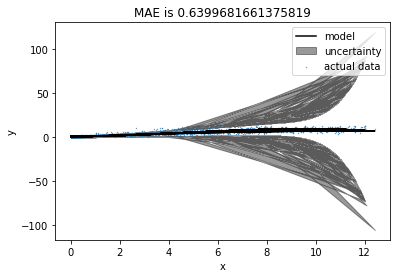

In [27]:
model.fit(X, Y)
model.plot(s=0.1)

Hmm, better. Now let's see how it fits after reducing the noise and setting the prior mean to zero vector again.

### Visualising the fit after reducing the noise

In [0]:
np.random.seed(seed)
X_init = np.linspace(-1, 1, 1000)
noise = np.random.randn(1000, ) * 0.5
Y = (5 * X_init**3 - 4 * X_init**2 + 3 * X_init - 2) + noise

In [0]:
S0 = np.eye(N_features)
M0 = np.zeros((N_features, ))
model = BLR(S0, M0)

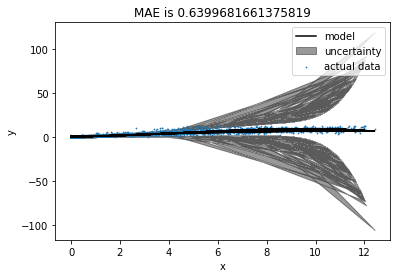

In [28]:
model.fit(X, Y)
model.plot(s=0.5)

When the noise was high, the model tended to align with the prior. After keeping the prior closer to the original coefficients, the model was improved as expected. From the last plot, we can say that as noise reduces from the data, the impact of the prior reduces, and the model tries to fit the data more precisely. Therefore, we can say that when data is too noisy or insufficient, a wisely chosen prior can produce a precise fit.

### Intuition to Active Learning (Uncertainty Sampling) with an example

Let's take the case where we want to train a machine learning model to classify if a person is infected with COVID-19 or not, but the testing facilities for the same are not available so widely. We may have very few amounts of data for detected positive and detected negative patients. Now, we want our model to be highly confident or least uncertain about its results; otherwise, it may create havoc for wrongly classified patients, but, our bottleneck is labeled data. Thanks to active learning techniques, we can overcome this problem smartly. How?

We train our model with existing data and test it on all the suspected patients' data. Let's say we have an uncertainty measure or confidence level about each tested data point (distance from the decision boundary in case of SVM, variance in case of Gaussian processes, or Bayesian Linear Regression). We can choose a patient for which our model is least certain, and send him to COVID-19 testing facilities (assuming that we can send only one patient at a time). Now, we can include his data to the train set and test the model on everyone else. By following the same procedure repeatedly, we can increase the size of our train data and confidence of the model without sending everyone randomly for testing.

This method is called Uncertainty Sampling in Active Learning. Now let's formally define Active Learning. From Wikipedia,

*Active learning is a special case of machine learning in which a learning algorithm can interactively query a user (or some other information source) to label new data points with the desired outputs.*

Now, we'll go through the active learning procedure step by step.

### Train set, test set, and pool. What is what?

The train set includes labeled data points. The pool includes potential data points to query for a label, and the test set includes labeled data points to check the performance of our model. Here, we cannot actually do a query to anyone, so we assume that we do not have labels for the pool while training, and after each iteration, we include a data point from the pool set to the train set for which our model has the highest uncertainty.

So, the algorithm can be represented as the following,

1.  Train the model with the train set.
2.  Test the performance on the test set (This should keep improving).   
3.  Test the model with the pool.
4.  Query for the most uncertain datapoint from the pool.
5.  Add that datapoint into the train set.
6.  Repeat step 1 to step 5 for $K$ iterations ($K$ ranges from $0$ to the pool size).

### Creating initial train set, test set, and pool

Let's take half of the dataset as the test set, and from another half, we will start with some points as the train set and remaining as the pool. Let's start with 2 data points as the train set.

In [0]:
#np.random.seed(seed)
#X_init = np.linspace(-1, 1, 1000)
#X = PolynomialFeatures(degree=5, include_bias=True).fit_transform(X_init.reshape(-1,1))
#noise = np.random.randn(1000, ) * 0.5
#Y = (5 * X_init**3 - 4 * X_init**2 + 3 * X_init - 2) + noise

In [29]:
train_pool_X, test_X, train_pool_Y, test_Y = train_test_split(X, Y, test_size = 0.5, random_state=seed)
train_X, pool_X, train_Y, pool_Y = train_test_split(train_pool_X, train_pool_Y, train_size=2, random_state=seed)

Visualizing train, test and pool.

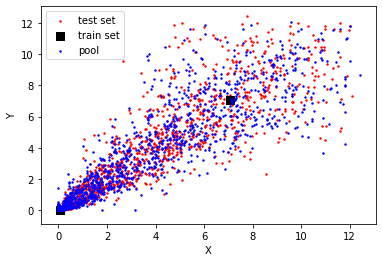

In [30]:
plt.scatter(test_X[:,1], test_Y, label='test set',color='r', s=2)
plt.scatter(train_X[:,1], train_Y, label='train set',marker='s',color='k', s=50)
plt.scatter(pool_X[:,1], pool_Y, label='pool',color='b', s=2)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

Let's initialize a few dictionaries to keep track of each iteration.

In [31]:
train_X_iter = {} # to store train points at each iteration
train_Y_iter = {} # to store corresponding labels to the train set at each iteration
models = {} # to store the models at each iteration
estimations = {} # to store the estimations on the test set at each iteration
test_mae_error = {} # to store MAE(Mean Absolute Error) at each iteration

### Training & testing initial learner on train set (Iteration 0)

Now we will train the model for the initial train set, which is iteration 0.

In [32]:
train_X_iter[0] = train_X
train_Y_iter[0] = train_Y

In [33]:
S0 = np.eye(N_features)
M0 = np.zeros((N_features, ))
models[0] = BLR(S0, M0)

In [34]:
models[0].fit(train_X_iter[0], train_Y_iter[0])

Creating a plot method to visualize train, test and pool with estimations and uncertainty.

In [35]:
def plot(ax, model, init_title=''):
  # Plotting the pool
  ax.scatter(pool_X[:,1], pool_Y, label='pool',s=1,color='r',alpha=0.4)
  
  # Plotting the test data
  ax.scatter(test_X[:,1], test_Y, label='test data',s=1, color='b', alpha=0.4)
  
  # Combining the test & the pool
  test_pool_X, test_pool_Y = np.append(test_X,pool_X, axis=0), np.append(test_Y,pool_Y)
  
  # Sorting test_pool for plotting
  sorted_inds = np.argsort(test_pool_X[:,1])
  test_pool_X, test_pool_Y = test_pool_X[sorted_inds], test_pool_Y[sorted_inds]
  
  # Plotting test_pool with uncertainty
  model.predict(test_pool_X)
  individual_var = model.pred_var.diagonal()
  ax.plot(test_pool_X[:,1], model.y_hat_map, color='black', label='model')
  ax.fill_between(test_pool_X[:,1], model.y_hat_map-individual_var, model.y_hat_map+individual_var
                  , alpha=0.2, color='black', label='uncertainty')
  
  # Plotting the train data
  ax.scatter(model.x[:,1], model.y,s=40, color='k', marker='s', label='train data')
  ax.scatter(model.x[-1,1], model.y[-1],s=80, color='r', marker='o', label='last added point')
  
  # Plotting MAE on the test set
  model.predict(test_X)
  ax.set_title(init_title+' MAE is '+str(np.mean(np.abs(test_Y - model.y_hat_map))))
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.legend()

Plotting the estimations and uncertainty.

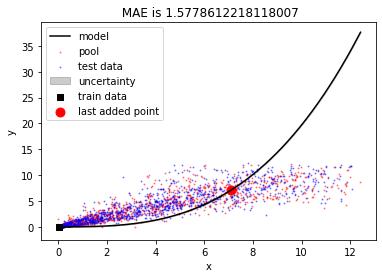

In [36]:
fig, ax = plt.subplots()
plot(ax, models[0])

Let's check the maximum uncertainty about any point for the model.

In [37]:
models[0].pred_var.diagonal().max()

1.760557359441268e-24

### increasing the number of training points

In [38]:
train_pool_X, test_X, train_pool_Y, test_Y = train_test_split(X, Y, test_size = 0.5, random_state=seed)
train_X, pool_X, train_Y, pool_Y = train_test_split(train_pool_X, train_pool_Y, train_size=7, random_state=seed)

In [39]:
train_X_iter[0] = train_X
train_Y_iter[0] = train_Y

In [40]:
S0 = np.eye(N_features)
M0 = np.zeros((N_features, ))
models[0] = BLR(S0, M0)

In [41]:
models[0].fit(train_X_iter[0], train_Y_iter[0])

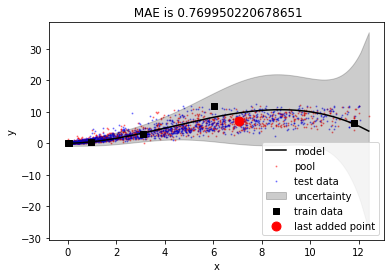

In [42]:
fig, ax = plt.subplots()
plot(ax, models[0])

Now uncertainty is visible, and currently, it's high at the right-most points. We are trying to fit a degree 5 polynomial here. So our linear regression coefficients are 6, including the bias.
Let's evaluate the performance on the test set.

In [43]:
estimations[0], _ = models[0].predict(test_X)
test_mae_error[0] = np.mean(np.abs(test_Y - estimations[0]))

Mean Absolute Error (MAE) on the test set is

In [44]:
test_mae_error[0]

0.769950220678651

### Moving the most uncertain point from the pool to the train set

In the previous plot, we saw that the model was least certain about the left-most point. We'll move that point from the pool to the train set and see the effect.

In [45]:
esimations_pool, _ = models[0].predict(pool_X)

Finding out a point having the most uncertainty.

In [46]:
in_var = models[0].pred_var.diagonal().argmax()
to_add_x = pool_X[in_var,:]
to_add_y = pool_Y[in_var]

Adding the point from the pool to the train set.

In [47]:
train_X_iter[1] = np.vstack([train_X_iter[0], to_add_x])
train_Y_iter[1] = np.append(train_Y_iter[0], to_add_y)

 Deleting the point from the pool.

In [48]:
pool_X = np.delete(pool_X, in_var, axis=0)
pool_Y = np.delete(pool_Y, in_var)

### Training again and visualising the results (Iteration 1)

This time, we will pass previously learnt prior to the next iteration.

In [49]:
S0 = np.eye(N_features)
models[1] = BLR(S0, models[0].MN)

In [50]:
models[1].fit(train_X_iter[1], train_Y_iter[1])

In [51]:
estimations[1], _ = models[1].predict(test_X)
test_mae_error[1] = np.mean(np.abs(test_Y - estimations[1]))

MAE on the test set is

In [52]:
test_mae_error[1]

0.7653651403362786

Visualizing the results.

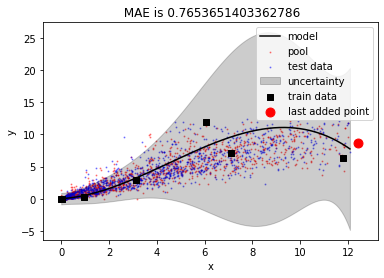

In [53]:
fig, ax = plt.subplots()
plot(ax, models[1])

Before & after adding most uncertain point

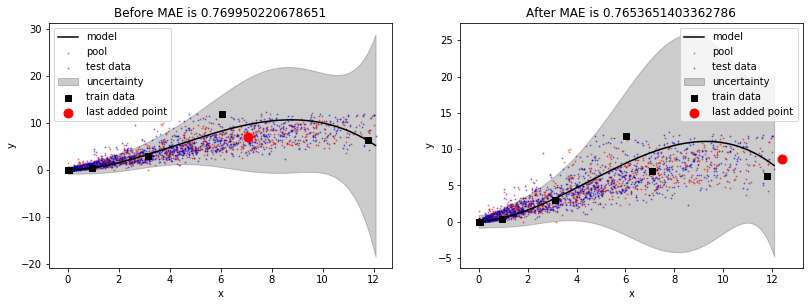

In [54]:
fig, ax = plt.subplots(1,2, figsize=(13.5,4.5))
plot(ax[0], models[0],'Before')
plot(ax[1], models[1],'After')

We can see that including most uncertain point into the train set has produced a better fit and MAE for test set has been reduced. Also, uncertainty has reduced at the left part of the data but it has increased a bit on the right part of the data.

Now let's do this for few more iterations in a loop and visualise the results.

### Active learning procedure

We can see that the point having highest uncertainty was chosen in first iteration and it produced the near optimal fit. After that, error reduced gradually. 

Now, let's put everything together and create a class for active learning procedure